Let's discuss a simplified version of the QARMAv2 cipher, specifically the QARMAv2-64-128 version.

## Round functions

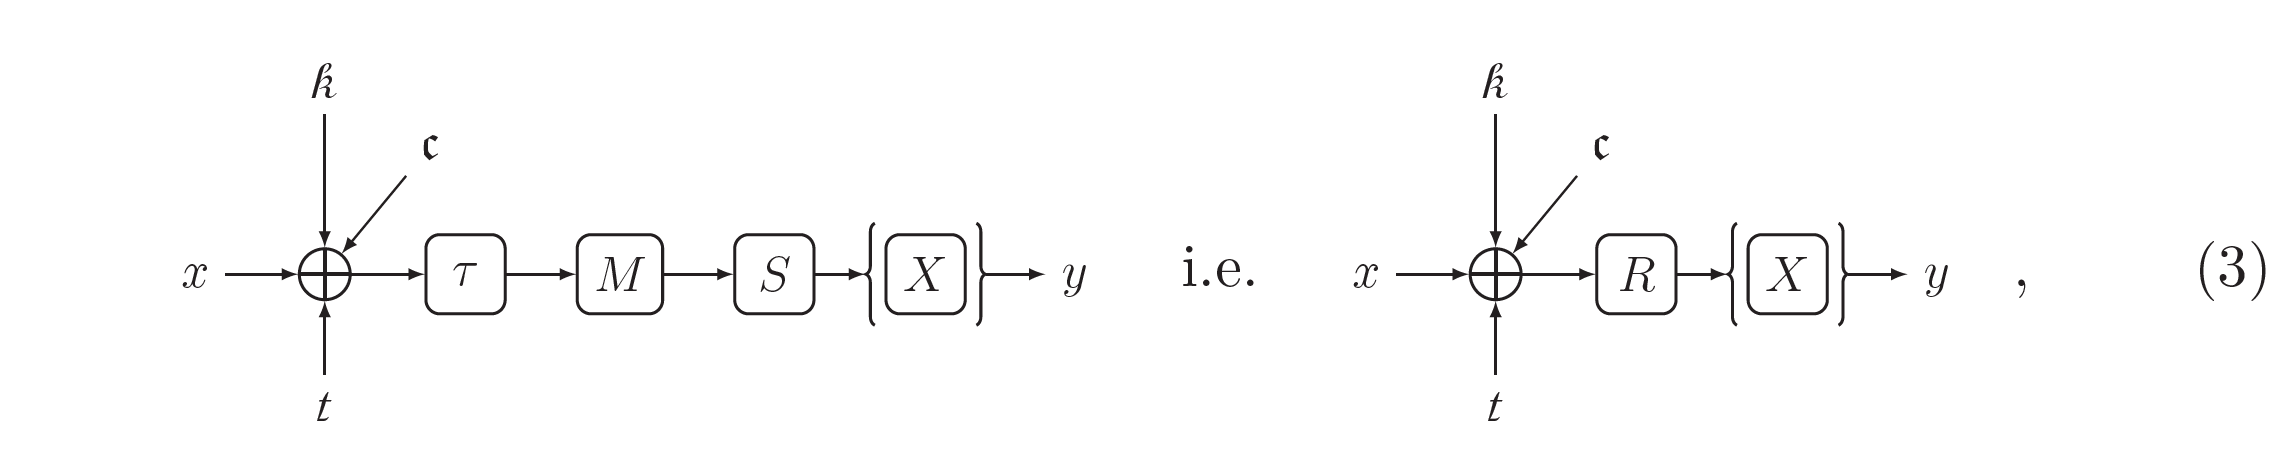

The round function is consist of tau_permutation, mix_columns, and S-box. 

In [22]:
# permutation functions
tau = [0, 11, 6, 13, 10, 1, 12, 7, 5, 14, 3, 8, 15, 4, 9, 2]
tau_inverse = [tau.index(i) for i in range(len(tau))]
print(tau_inverse)
def permutation(state: list, p: list) -> list:
    return [state[p[i]] for i in range(len(state))]


state = [i for i in range(16)]
state = permutation(state, tau)
if state == tau:
    print("permutation function is working")
if permutation(state, tau_inverse) == [i for i in range(16)]:
    print("inverse permutation function is working")

[0, 5, 15, 10, 13, 8, 2, 7, 11, 14, 4, 1, 6, 3, 9, 12]
permutation function is working
inverse permutation function is working


$\rho((x_3, x_2, x_1, x_0)) = (x_2, x_1, x_0, x_3)$ 

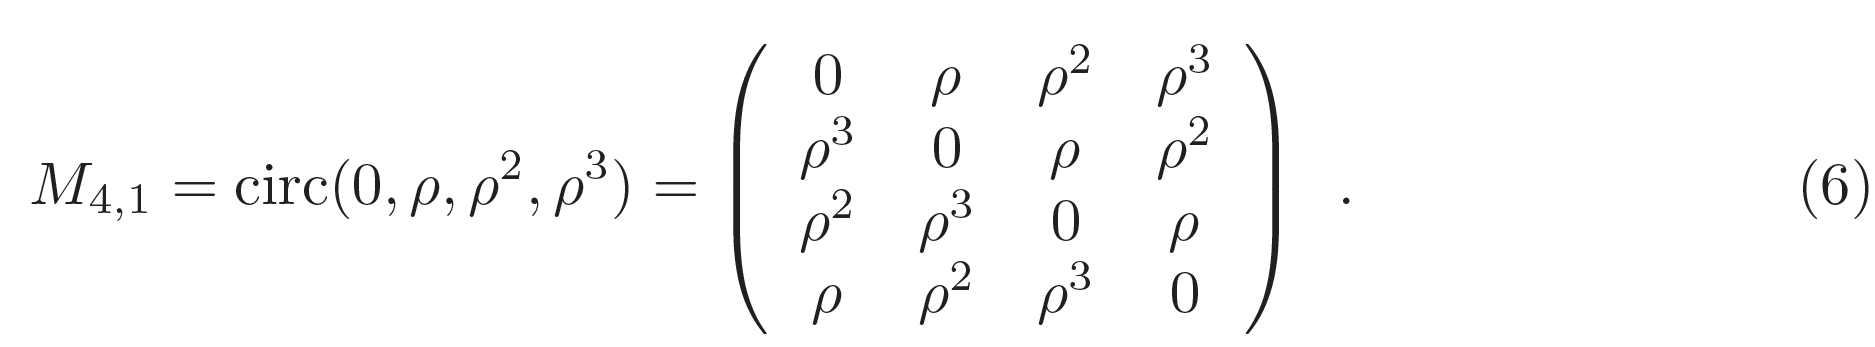

In [23]:
# the rho is represent by rotate_left(value,1)
def rotate_left(value: int, shift: int) -> int:
    return ((value << shift) | (value >> (4 - shift))) & 0xF


value = 0b0010
shift_amount = 4
bin(rotate_left(value, shift_amount))

'0b10'

In [24]:
# perfectly working
# the mix_column is involution, amazing thing !!!
def mix_column(state: list) -> list:
    result = state[:]
    for i in range(4):
        for j in range(4):
            index = i + j * 4
            result[index] = (
                rotate_left(state[(index + 4) % 16], 1)
                ^ rotate_left(state[(index + 8) % 16], 2)
                ^ rotate_left(state[(index + 12) % 16], 3)
            )
    return result


# state = [8] * 4 + [4] * 4 + [2] * 4 + [1] * 4
state = [8, 4, 2, 1] * 4
print(mix_column(state))
print(mix_column(mix_column(state)))

[7, 11, 13, 14, 7, 11, 13, 14, 7, 11, 13, 14, 7, 11, 13, 14]
[8, 4, 2, 1, 8, 4, 2, 1, 8, 4, 2, 1, 8, 4, 2, 1]


In [25]:
S = [0x4, 0x7, 0x9, 0xB, 0xC, 0x6, 0xE, 0xF, 0x0, 0x5, 0x1, 0xD, 0x8, 0x3, 0x2, 0xA]
S_inverse = [S.index(i) for i in range(len(S))]

print(S)
print(S_inverse)

def s_box(state: list, S: list) -> list:
    return [S[state[i]] for i in range(len(state))]


state = [i for i in range(16)]
state = s_box(state, S)
if state == S:
    print("s_box function is working")
if s_box(state, S_inverse) == [i for i in range(16)]:
    print("inverse s_box function is working")

[4, 7, 9, 11, 12, 6, 14, 15, 0, 5, 1, 13, 8, 3, 2, 10]
[8, 10, 14, 13, 0, 9, 5, 1, 12, 2, 15, 3, 4, 11, 6, 7]
s_box function is working
inverse s_box function is working


## The Round Keys

$o(w):=(w>>>1)+(w>>(b-1))(8)$

$o^{-1}(w) := (w<<<1)+ (w>>(b-3)\&2)$

$K = K_0||K_1$

$\iota_e:(K_0,K_1)\mapsto(L_0,L_1):=(o(K_0)+\alpha,o^{-1}(K_1)+\beta)$

$W_0 = o^2(K_0) \, W_1 = o^{−2}(K_1)$

In [26]:
def o_func(w: int, b: int) -> int:
    t1 = (w >> 1) | (w << (b - 1)) & ((1 << b) - 1)
    t2 = w >> (b - 1)
    return t1 ^ t2

def o_func_inverse(w: int, b: int) -> int:
    t1 = (w << 1) & ((1 << b) - 1) | (w >> (b - 1)) 
    t2 = w >> (b-3) & (2) 
    return t1 ^ t2

w = 0x8000000000000000
b = 64
w = o_func(w, b)
print(hex(w))
if o_func_inverse(w, b) == 0x8000000000000000:
    print("o_func and o_func_inverse are working")

0x4000000000000001
o_func and o_func_inverse are working


## The Round constants

The 64 most significant bits of the round constant $c_2$ (the first non-zero round constant) are given by $0x243F6A8885A308D3$,and each successive value is obtained from the LFSR’s state after applying the LFSR 23 times. We call this update function $\varPsi$.

The 64 most significant bits of $\alpha$ are given by $\alpha_0 = 0x13198A2E03707344$. The 64 least significant bits if $\alpha$ (for $\ell = 2$) and β are generated from this seed in the same way as the c’s, i.e. $\beta:= \varPsi(\alpha)$ for $\ell = 1$, and $\alpha = \alpha_0∥\varPsi(\alpha_0),\beta = \varPsi^2(\alpha_0)∥\varPsi^3(\alpha_0)$ for  $\ell = 2$.

In [27]:
def psi_func(input: int) -> int:
    """
    LFSR ticked 23 times on 64-bit number. the primitive polynomial is x^64 + x^50 + x^33 + x^19 + 1

    Parameters:
    input (int): The input value to be processed.

    Returns:
    int: The result of the bitwise operations.
    """
    spill = input >> 51
    tmp = (
        (input << 13) & ((1 << 64) - 1)
        ^ (spill << 50)
        ^ (spill << 33)
        ^ (spill << 19)
        ^ spill
    )
    spill = tmp >> 54
    tmp = (
        (tmp << 10) & ((1 << 64) - 1)
        ^ (spill << 50)
        ^ (spill << 33)
        ^ (spill << 19)
        ^ spill
    )
    return tmp


alpha = 0x13198A2E03707344
beta = psi_func(alpha)
print(f"beta {hex(beta)}")
c2 = 0x243F_6A88_85A3_08D3

beta 0x249ea1b3c5118ce3


## The Tweak Schedule

$\varphi=\tau_f:[1, 10, 14, 6, 2, 9, 13, 5, 0, 8, 12, 4, 3, 11, 15, 7]\,for\, \ell=1$

$\varphi=\tau_F:[1, 10, 14, 22, 18, 25, 29, 21, 0, 8, 12, 4, 19, 27, 31, 23,\\
17, 26, 30, 6, 2, 9, 13, 5, 16, 24, 28, 20, 3, 11, 15, 7]\,for\, \ell=2.$

In [28]:
tau_f = [1, 10, 14, 6, 2, 9, 13, 5, 0, 8, 12, 4, 3, 11, 15, 7]
tau_f_inverse = [tau_f.index(i) for i in range(len(tau_f))]
print(tau_f_inverse)

[8, 0, 4, 12, 11, 7, 3, 15, 9, 5, 1, 13, 10, 6, 2, 14]


## Specific of the cipher

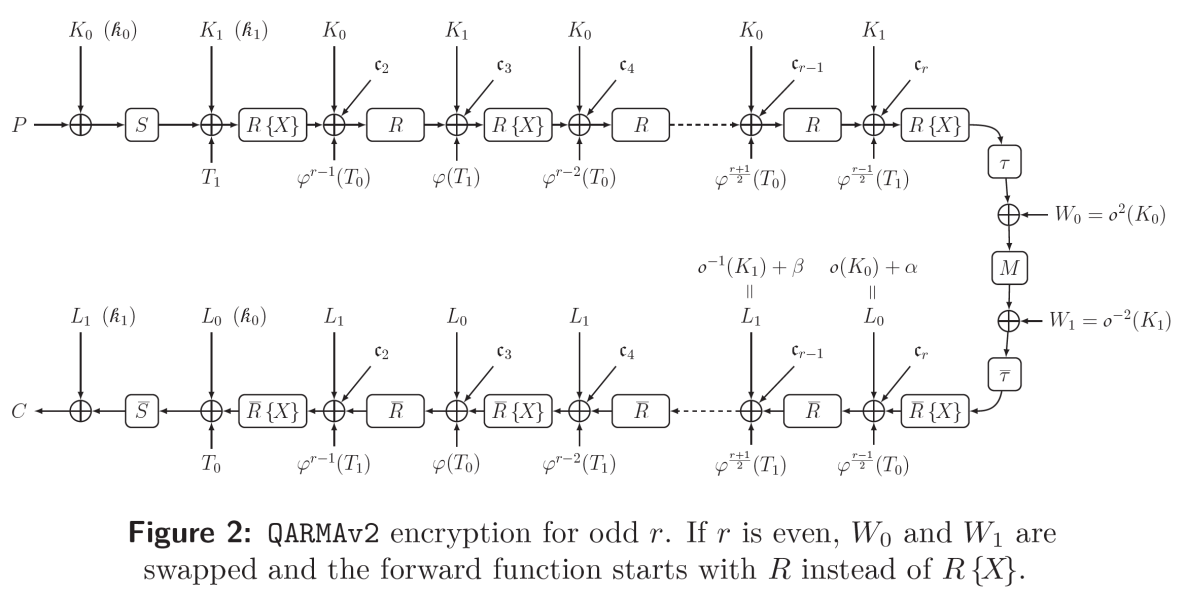

In [29]:
def int_to_4bit_list(P):
    return [(P >> i) & 0xF for i in range(0, 64, 4)][::-1]

# Usage:
P = 0x123456789ABCDEF0
print(int_to_4bit_list(P))

def bit_list_to_int(bit_list):
    result = 0
    for bit in bit_list:
        result = (result << 4) | bit
    return result

# Usage:
bit_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0]
print(hex(bit_list_to_int(bit_list)))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0]
0x123456789abcdef0


In [43]:
# input data
P = 0x0000000000000000
K0, K1 = 0x0123456789ABCDEF, 0xFEDCBA9876543210
T0, T1 = 0x7E5C3A18F6D4B290, 0x1EB852FC9630DA74
W0 = o_func(o_func(K0, 64), 64)
W1 = o_func_inverse(o_func_inverse(K1, 64), 64)



# cipher of r = 5
r = 5

T0 = int_to_4bit_list(T0)
for i in range(r - 1):
    T0 = permutation(T0, tau_f)
T0 = bit_list_to_int(T0)


t0, t1 = T0, T1
k0, k1 = K0, K1
state = int_to_4bit_list(P ^ k0)
state = s_box(state, S)


cs = [0, 0, c2]
for i in range(3, r + 1):
    cs.append(psi_func(cs[-1]))


for i in range(1, r + 1):
    state = bit_list_to_int(state)
    
    if i % 2 == 1:
        state = state ^ k1 ^ t1
        
    else:
        state = state ^ k0 ^ t0
     
    state = state ^ cs[i]
   
    state = int_to_4bit_list(state)
    state = permutation(state, tau)
    state = mix_column(state)
    state = s_box(state, S)
   
    if i % 2 == 1:
        t1 = permutation(int_to_4bit_list(t1), tau_f)
        t1 = bit_list_to_int(t1)
    else:
        t0 = permutation(int_to_4bit_list(t0), tau_f_inverse)
        t0 = bit_list_to_int(t0)

k0 = o_func(k0, 64) ^ alpha
k1 = o_func_inverse(k1, 64) ^ beta

W0 = int_to_4bit_list(W0)
W1 = int_to_4bit_list(W1)

state = permutation(state, tau)
state = [state[i] ^ W0[i] for i in range(16)]
state = mix_column(state)
state = [state[i] ^ W1[i] for i in range(16)]
state = permutation(state, tau_inverse)

W0 = bit_list_to_int(W0)
W1 = bit_list_to_int(W1)

for i in range(r, 0, -1):
    state = s_box(state, S_inverse)
    state = mix_column(state)
    state = permutation(state, tau_inverse)

    state = bit_list_to_int(state)
    state = state ^ cs[i]

    if (i + 1) % 2 == 1:
        state = state ^ k1 ^ t1
    else:
        state = state ^ k0 ^ t0
    state = int_to_4bit_list(state)

    if i > 1 and i % 2 == 0:
        t1 = permutation(int_to_4bit_list(t1), tau_f)
        t1 = bit_list_to_int(t1)
    else:
        t0 = permutation(int_to_4bit_list(t0), tau_f_inverse)
        t0 = bit_list_to_int(t0)

state = s_box(state, S_inverse)
state = bit_list_to_int(state)
cipher = state ^ k1

except_cipher = 0x76D5422B082E32AD
if cipher == except_cipher:
    print("cipher is correct")

cipher is correct
